In [1]:
!mkdir ~/.kaggle
!echo "{\"username\":\"dhritijha1\",\"key\":\"4f4a65df98f953741f0f41a0e643fd92\"}" > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d sovitrath/road-lane-instance-segmentation

Dataset URL: https://www.kaggle.com/datasets/sovitrath/road-lane-instance-segmentation
License(s): CC-BY-SA-4.0
 97% 45.0M/46.2M [00:00<00:00, 132MB/s] 
100% 46.2M/46.2M [00:00<00:00, 122MB/s]


In [3]:
!mkdir dataset
!unzip /content/road-lane-instance-segmentation.zip

Archive:  /content/road-lane-instance-segmentation.zip
  inflating: road_lane_instance_segmentation/README.dataset.txt  
  inflating: road_lane_instance_segmentation/README.roboflow.txt  
  inflating: road_lane_instance_segmentation/annotations/instances_train2017.json  
  inflating: road_lane_instance_segmentation/annotations/instances_val2017.json  
  inflating: road_lane_instance_segmentation/train2017/2023-06-15_14-06-50-front_mp4_0_jpg.rf.0792eb3c2145b288b835bca1818dc742.jpg  
  inflating: road_lane_instance_segmentation/train2017/2023-06-15_14-06-50-front_mp4_1080_jpg.rf.9687bb28777e238b49476f3cee47c1ea.jpg  
  inflating: road_lane_instance_segmentation/train2017/2023-06-15_14-06-50-front_mp4_1200_jpg.rf.643c16f9081cf35fda65764b62807275.jpg  
  inflating: road_lane_instance_segmentation/train2017/2023-06-15_14-06-50-front_mp4_1320_jpg.rf.8f84d350eeca2e62781b92081324d902.jpg  
  inflating: road_lane_instance_segmentation/train2017/2023-06-15_14-06-50-front_mp4_1380_jpg.rf.76527487

In [ ]:
# Libraries for working with image processing
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def region_selection(image):
    """
    Determine and cut the region of interest in the input image.
    Parameters:
        image: we pass here the output from canny where we have
        identified edges in the frame
    """
    # create an array of the same size as of the input image
    mask = np.zeros_like(image)
    # if you pass an image with more then one channel
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    # our image only has one channel so it will go under "else"
    else:
          # color of the mask polygon (white)
        ignore_mask_color = 255
    # creating a polygon to focus only on the road in the picture
    # we have created this polygon in accordance to how the camera was placed
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.1, rows * 0.70]
    bottom_right = [cols * 1.0, rows * 0.95]
    top_right    = [cols * 1.0, rows * 0.70]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    # filling the polygon with white color and generating the final mask
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # performing Bitwise AND on the input image and mask to get only the edges on the road
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def hough_transform(image):
    """
    Determine and cut the region of interest in the input image.
    Parameter:
        image: grayscale image which should be an output from the edge detector
    """
    # Distance resolution of the accumulator in pixels.
    rho = 1
    # Angle resolution of the accumulator in radians.
    theta = np.pi/180
    # Only lines that are greater than threshold will be returned.
    threshold = 20
    # Line segments shorter than that are rejected.
    minLineLength = 20
    # Maximum allowed gap between points on the same line to link them
    maxLineGap = 500
    # function returns an array containing dimensions of straight lines
    # appearing in the input image
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

def average_slope_intercept(lines):
    """
    Find the slope and intercept of all lanes in the image.
    Parameters:
        lines: output from Hough Transform
    """
    lane_lines = []  # List to hold all lane lines (slope, intercept)
    weights = []     # List to hold the weights (lengths) of the lines

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            # calculating slope of a line
            slope = (y2 - y1) / (x2 - x1)
            if abs(slope) < 1/2:
              continue
            # calculating intercept of a line
            intercept = y1 - (slope * x1)
            # calculating length of a line
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            lane_lines.append((slope, intercept))
            weights.append(length)

    # Return the average slope and intercept for all lanes
    return lane_lines, weights

def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    try:
      x1 = int((y1 - intercept)/slope)
      x2 = int((y2 - intercept)/slope)
      y1 = int(y1)
      y2 = int(y2)
      return ((x1, y1), (x2, y2))
    except:
      return((0, int(y1)), (0, int(y2)))

def lane_lines(image, lines):
    """
    Create full length lines from pixel points for all lanes.
    Parameters:
        image: The input test image.
        lines: The output lines from Hough Transform.
    """
    lane_lines, weights = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    full_lines = []
    for lane in lane_lines:
        line = pixel_points(y1, y2, lane)
        if line is not None:
            full_lines.append(line)
    return full_lines


def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    """
    Draw lines onto the input image.
    Parameters:
        image: The input test image (video frame in our case).
        lines: The output lines from Hough Transform.
        color (Default = red): Line color.
        thickness (Default = 12): Line thickness.
    """
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

def frame_processor(image, gaussian_blur=5):
    """
    Process the input frame to detect lane lines.
    Parameters:
        image: image of a road where one wants to detect lane lines
        (we will be passing frames of video to this function)
    """
    # convert the RGB image to Gray scale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # applying gaussian Blur which removes noise from the image
    # and focuses on our region of interest
    kernel_size = gaussian_blur
    blur = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    low_t = 50
    high_t = 150
    edges = cv2.Canny(blur, low_t, high_t)
    plt.imshow(edges)
    plt.show()
    region = region_selection(edges)
    hough = hough_transform(region)

    # Draw all lane lines detected
    result = draw_lane_lines(image, lane_lines(image, hough))
    return result



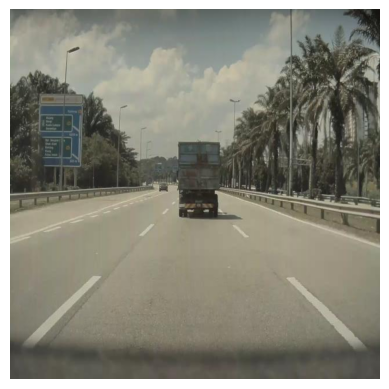

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

I = io.imread("/content/road_lane_instance_segmentation/train2017/2023-06-15_14-12-53-front_mp4_180_jpg.rf.30c46873e1a23aea7e9d0bc38090f691.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

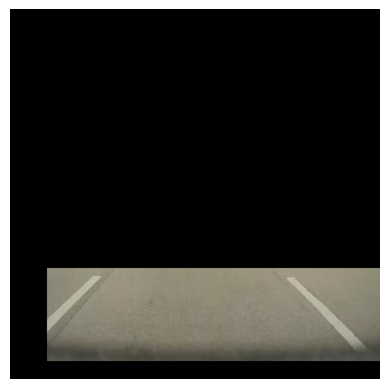

In [ ]:
I2 = region_selection(I)
plt.axis('off')
plt.imshow(I2)

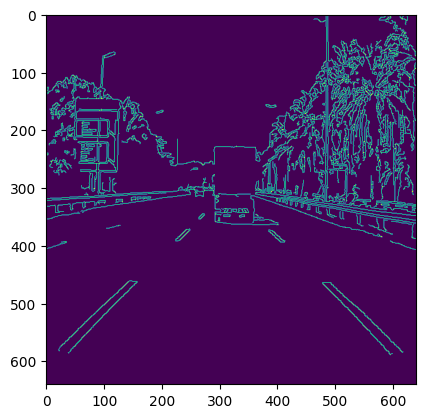

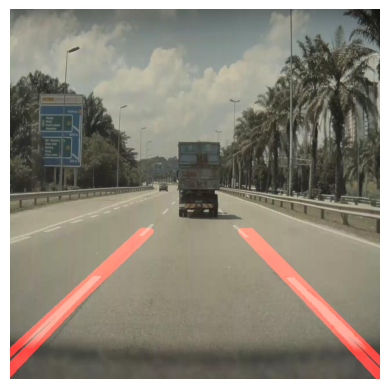

In [ ]:
I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

In [ ]:
import numpy as np
import cv2

def create_lane_bitmap(image, lane_lines):
    """
    Create a bitmap with the regions between multiple lanes marked as black, and the rest as white.
    Parameters:
        image: The original image (for size reference).
        lane_lines: A list of left and right lane segments. Each lane is represented as
                    a tuple ((x1, y1), (x2, y2)).
    Returns:
        A binary (black and white) image with the lane regions marked.
    """
    # Create a blank white image (same size as input)
    height, width = image.shape[:2]
    mask = np.ones((height, width), dtype=np.uint8) * 255  # White image

    if not lane_lines or len(lane_lines) < 2:
        # If not enough lane lines are detected, return the white image
        return mask

    # Extract left and right lane segments
    left_lines = [line for line in lane_lines if line[0][0] < width // 2]  # Left of image center
    right_lines = [line for line in lane_lines if line[0][0] >= width // 2]  # Right of image center

    if not left_lines or not right_lines:
        # If no valid left or right lines are found, return the white image
        return mask

    # Sort the left and right lines by their y-coordinates (from bottom to top)
    left_lines = sorted(left_lines, key=lambda line: line[0][1], reverse=True)
    right_lines = sorted(right_lines, key=lambda line: line[0][1], reverse=True)

    # We will fill the area between corresponding left and right lines
    for left_line, right_line in zip(left_lines, right_lines):
        left_x1, left_y1 = left_line[0]
        left_x2, left_y2 = left_line[1]
        right_x1, right_y1 = right_line[0]
        right_x2, right_y2 = right_line[1]

        # Define the polygon that represents the area between the current left and right lane
        lane_polygon = np.array([
            [left_x1, left_y1],  # Bottom left of the left lane
            [left_x2, left_y2],  # Top left of the left lane
            [right_x2, right_y2],  # Top right of the right lane
            [right_x1, right_y1]  # Bottom right of the right lane
        ], dtype=np.int32)

        # Fill the region between the lanes with black (0 value)
        cv2.fillPoly(mask, [lane_polygon], 0)  # Black polygon in the mask

    return mask

def process_frame_for_bitmap(image,gaussian_blur=3):
    """
    Process the frame to detect lanes and create a bitmap showing lane regions.
    """
    kernel_size = gaussian_blur
    blur = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    # Detect lane lines in the frame (you would have this from your lane detection code)
    edges = cv2.Canny(blur, 50, 150)  # For illustration, applying edge detection
    region = region_selection(edges)  # Focus on the road region
    lines = hough_transform(region)  # Get lines using Hough Transform
    lane_line_segments = lane_lines(image, lines)  # Get all detected lane line segments

    # Create bitmap showing lane regions
    bitmap_output = create_lane_bitmap(image, lane_line_segments)

    return bitmap_output

In [ ]:
BBBBBBBBBBBBBBBBBBBBBBBBBBBBBB6

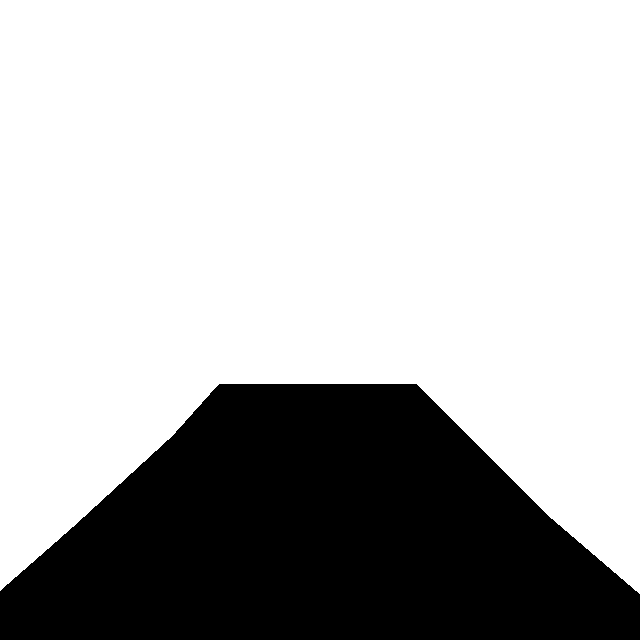

True

In [ ]:
#image = cv2.imread(I)  # Load your image or frame
bitmap_output = process_frame_for_bitmap(I)
cv2_imshow(bitmap_output)  # Show the resulting bitmap
cv2.imwrite('lane_bitmap.jpg', bitmap_output)  # Save the result

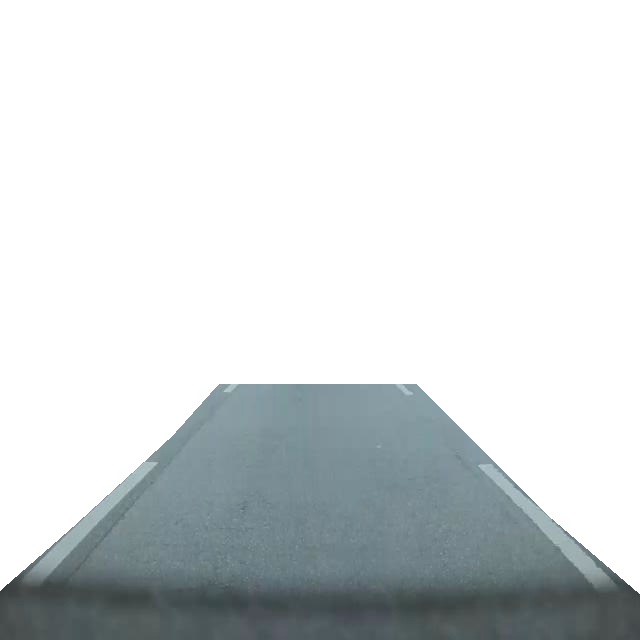

In [ ]:
import numpy as np
import cv2

def restore_lane_region(image, lane_mask):
    """
    Retain the lane regions from the original image and keep the non-lane regions as white.

    Parameters:
        image: The original image.
        lane_mask: The binary lane mask where lane regions are black (0), and the rest is white (255).

    Returns:
        An image with the original lane regions and white background elsewhere.
    """
    # Create a copy of the original image
    restored_image = np.ones_like(image) * 255  # White background

    # Invert the lane mask (so that the lane regions are 255, and the rest is 0)
    inverted_mask = cv2.bitwise_not(lane_mask)

    # Use the inverted mask to retain the lane regions in the original image
    lane_regions = cv2.bitwise_and(image, image, mask=inverted_mask)

    # Combine the white background and the lane regions
    restored_image = np.where(lane_regions != 0, lane_regions, restored_image)

    return restored_image

def process_frame_for_bitmap(image,gaussian_blur=3):
    """
    Process the frame to detect lanes and create a bitmap showing lane regions.
    """
    kernel_size = gaussian_blur
    blur = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    # Detect lane lines in the frame (you would have this from your lane detection code)
    edges = cv2.Canny(blur, 50, 150)  # For illustration, applying edge detection
    region = region_selection(edges)  # Focus on the road region
    lines = hough_transform(region)  # Get lines using Hough Transform
    lane_line_segments = lane_lines(image, lines)  # Get all detected lane line segments

    # Create bitmap showing lane regions
    lane_mask = create_lane_bitmap(image, lane_line_segments)

    # Create the restored image with lane regions and white background
    restored_image = restore_lane_region(image, lane_mask)

    return restored_image

# Example usage
#image = cv2.imread('road_image.jpg')  # Load the original image
restored_image = process_frame_for_bitmap(I)

cv2_imshow(restored_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


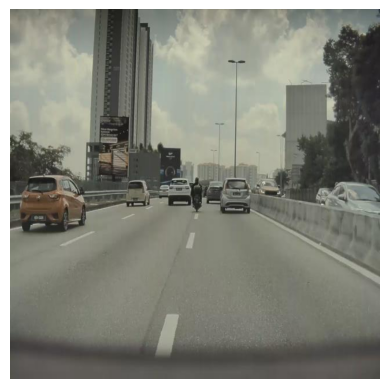

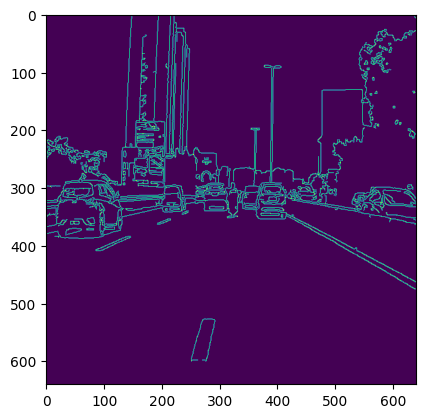

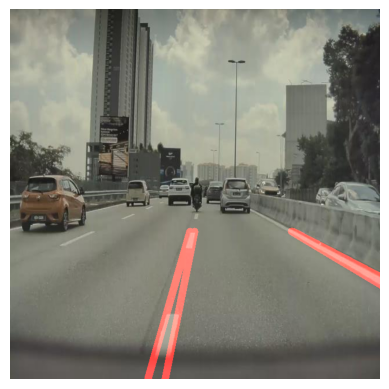

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/val2017/2023-06-15_14-37-01-front_mp4_720_jpg.rf.d1062409b36db395de1844bbd63afe7c.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

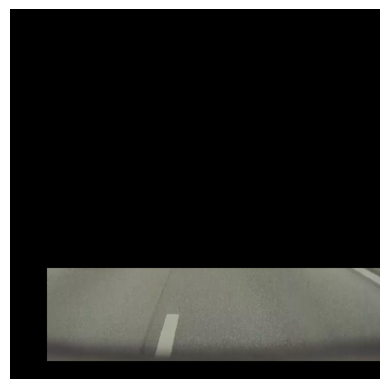

In [ ]:
I2 = region_selection(I)
plt.axis('off')
plt.imshow(I2)

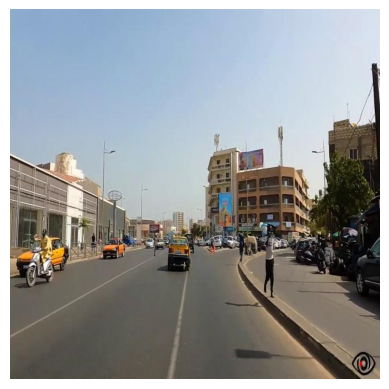

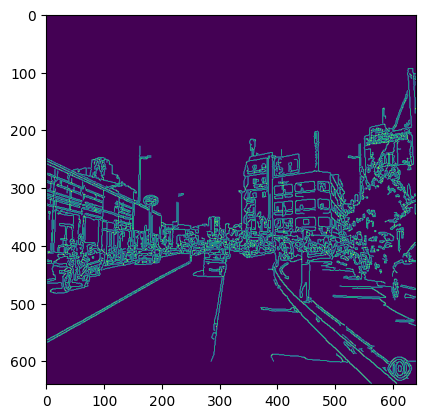

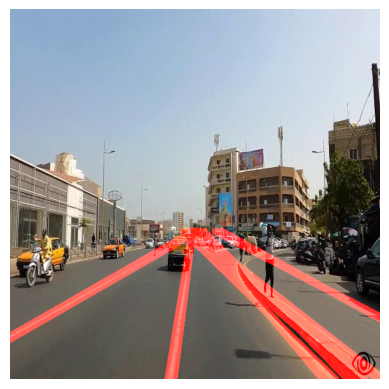

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/val2017/Virtual_Driving_Tour_around_Senegal_mp4_16140_jpg.rf.a6be253a17566b165d0a83140f9f68d1.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

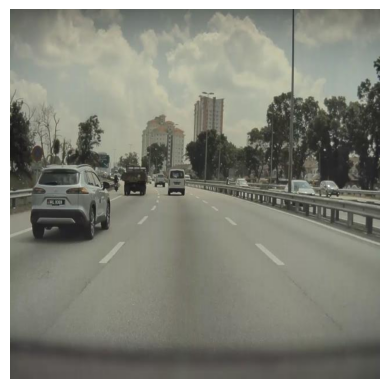

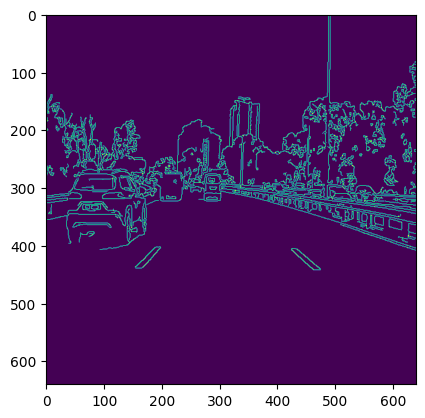

TypeError: 'NoneType' object is not iterable

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/val2017/2023-06-15_14-16-54-front_mp4_720_jpg.rf.4f16dfc9aaa390ca20db04d7890ddb00.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)



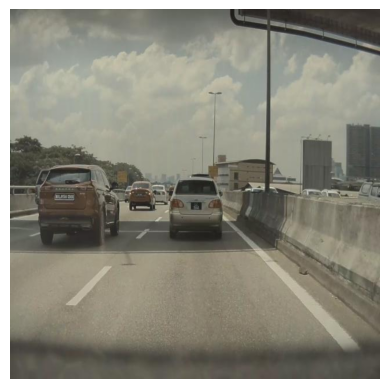

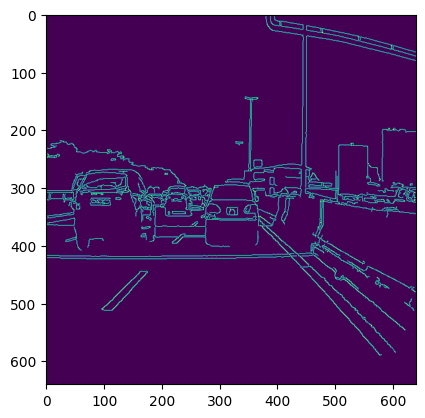

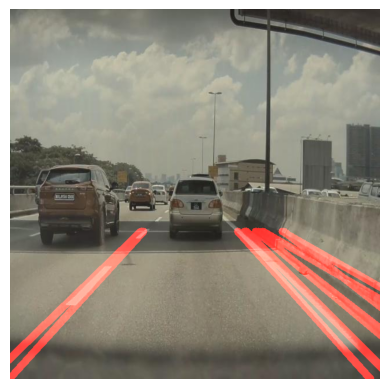

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/train2017/2023-06-15_14-23-57-front_mp4_240_jpg.rf.f5dc436810dd0d495da8046a538e2b69.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

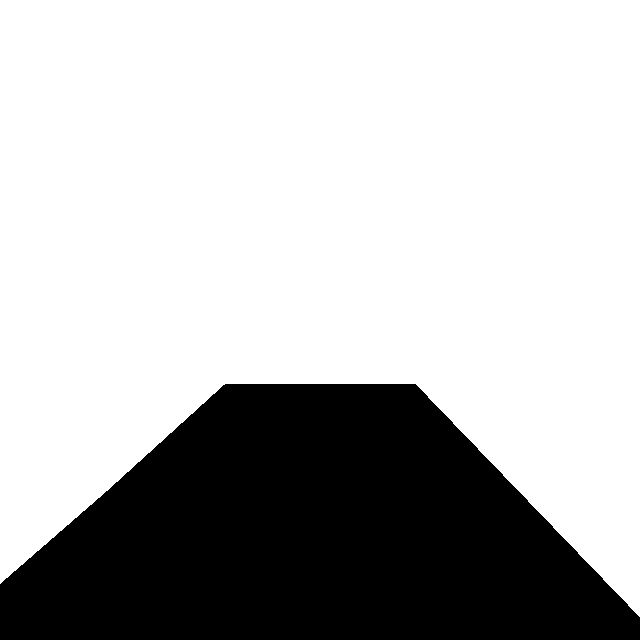

True

In [ ]:
import numpy as np
import cv2

def create_lane_bitmap(image, lane_lines):
    """
    Create a bitmap with the regions between multiple lanes marked as black, and the rest as white.
    Parameters:
        image: The original image (for size reference).
        lane_lines: A list of left and right lane segments. Each lane is represented as
                    a tuple ((x1, y1), (x2, y2)).
    Returns:
        A binary (black and white) image with the lane regions marked.
    """
    # Create a blank white image (same size as input)
    height, width = image.shape[:2]
    mask = np.ones((height, width), dtype=np.uint8) * 255  # White image

    if not lane_lines or len(lane_lines) < 2:
        # If not enough lane lines are detected, return the white image
        return mask

    # Extract left and right lane segments
    left_lines = [line for line in lane_lines if line[0][0] < width // 2]  # Left of image center
    right_lines = [line for line in lane_lines if line[0][0] >= width // 2]  # Right of image center

    if not left_lines or not right_lines:
        # If no valid left or right lines are found, return the white image
        return mask

    # Sort the left and right lines by their y-coordinates (from bottom to top)
    left_lines = sorted(left_lines, key=lambda line: line[0][1], reverse=True)
    right_lines = sorted(right_lines, key=lambda line: line[0][1], reverse=True)

    # We will fill the area between corresponding left and right lines
    for left_line, right_line in zip(left_lines, right_lines):
        left_x1, left_y1 = left_line[0]
        left_x2, left_y2 = left_line[1]
        right_x1, right_y1 = right_line[0]
        right_x2, right_y2 = right_line[1]

        # Define the polygon that represents the area between the current left and right lane
        lane_polygon = np.array([
            [left_x1, left_y1],  # Bottom left of the left lane
            [left_x2, left_y2],  # Top left of the left lane
            [right_x2, right_y2],  # Top right of the right lane
            [right_x1, right_y1]  # Bottom right of the right lane
        ], dtype=np.int32)

        # Fill the region between the lanes with black (0 value)
        cv2.fillPoly(mask, [lane_polygon], 0)  # Black polygon in the mask

    return mask

def process_frame_for_bitmap(image):
    """
    Process the frame to detect lanes and create a bitmap showing lane regions.
    """
    # Detect lane lines in the frame (you would have this from your lane detection code)
    edges = cv2.Canny(image, 50, 150)  # For illustration, applying edge detection
    region = region_selection(edges)  # Focus on the road region
    lines = hough_transform(region)  # Get lines using Hough Transform
    lane_line_segments = lane_lines(image, lines)  # Get all detected lane line segments

    # Create bitmap showing lane regions
    bitmap_output = create_lane_bitmap(image, lane_line_segments)

    return bitmap_output

# Example usage
image = cv2.imread('/content/road_lane_instance_segmentation/train2017/2023-06-15_14-23-57-front_mp4_1980_jpg.rf.8200565878af7f57f6aa58c5b3f13dd7.jpg')  # Load your image or frame
bitmap_output = process_frame_for_bitmap(image)
cv2_imshow(bitmap_output)  # Show the resulting bitmap
cv2.imwrite('lane_bitmap.jpg', bitmap_output)  # Save the result


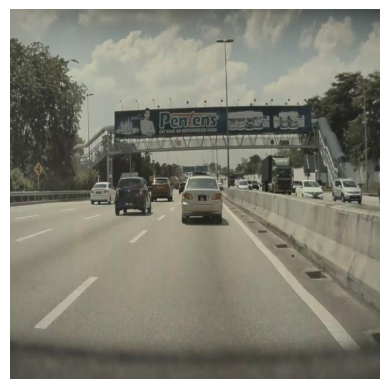

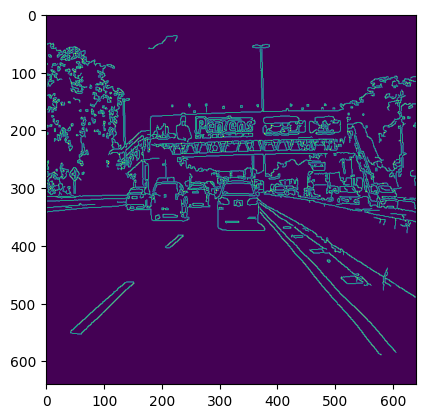

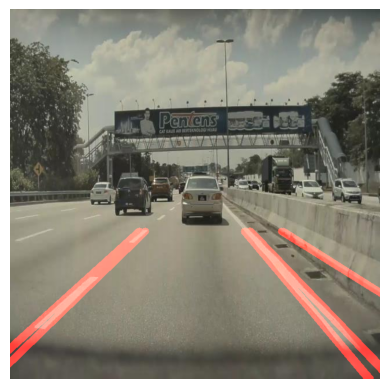

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/train2017/2023-06-15_14-23-57-front_mp4_1980_jpg.rf.8200565878af7f57f6aa58c5b3f13dd7.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

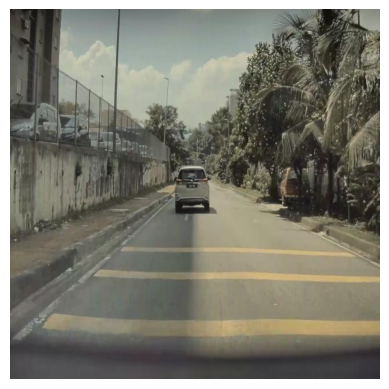

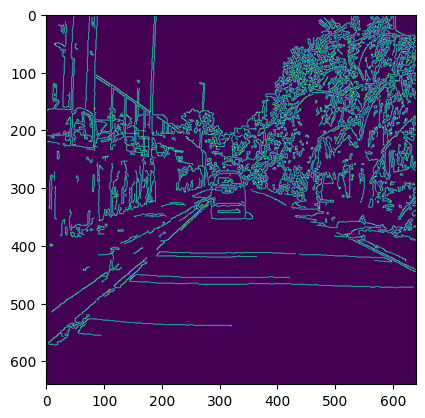

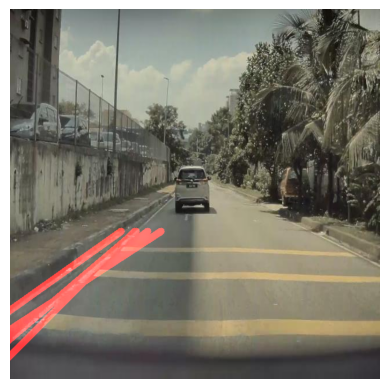

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/train2017/2023-06-15_14-41-02-front_mp4_1680_jpg.rf.949e07567a0d81024390d35a4a49366a.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

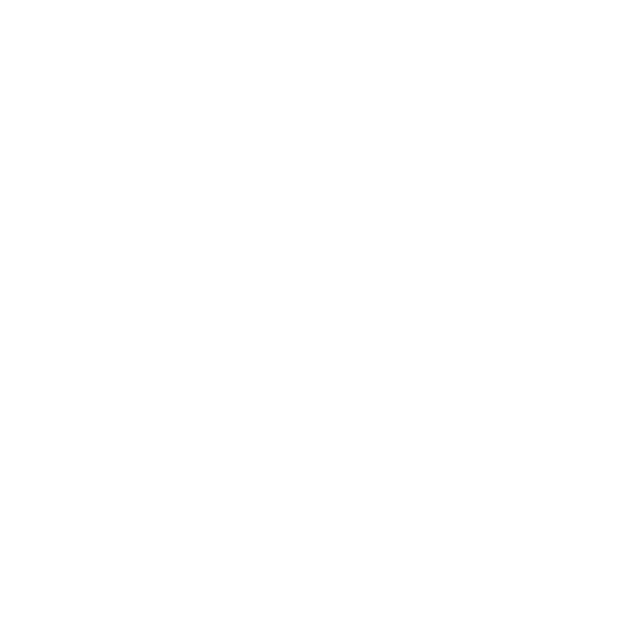

In [ ]:
cv2_imshow(process_frame_for_bitmap(I))

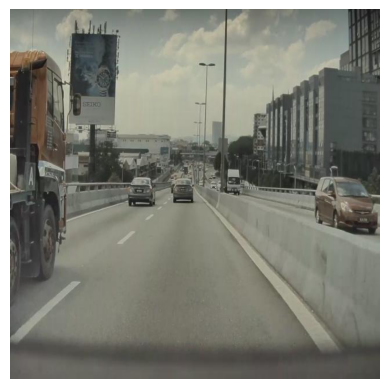

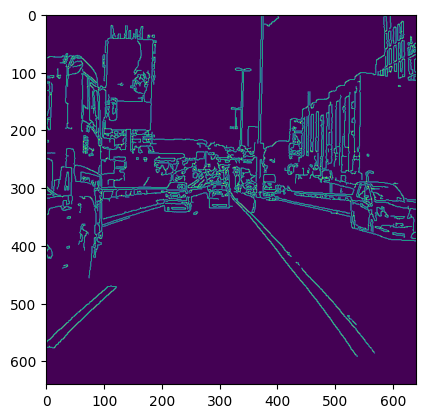

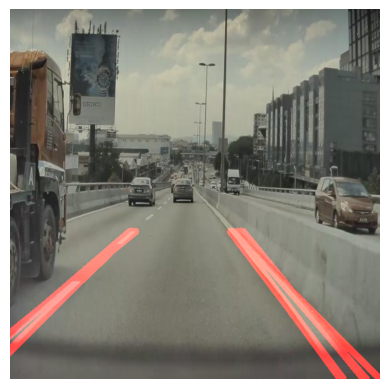

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/train2017/2023-06-15_14-35-00-front_mp4_1320_jpg.rf.2b69616be5f5b5b2a0a602dd4bec3fd0.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

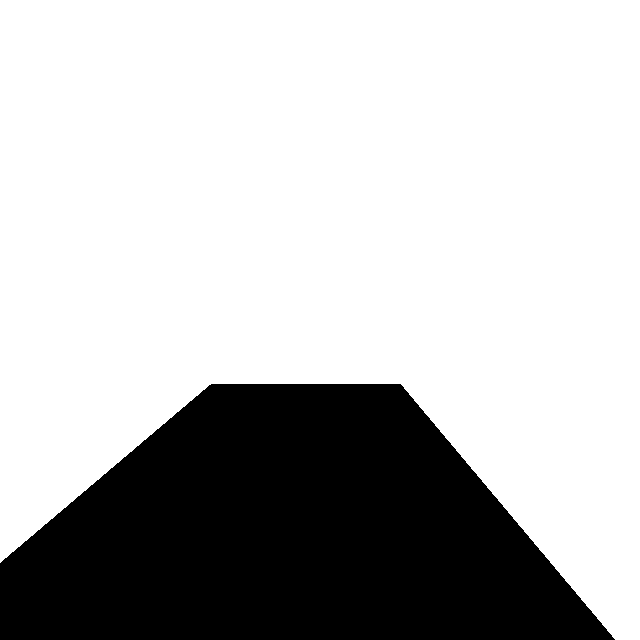

In [ ]:
cv2_imshow(process_frame_for_bitmap(I))

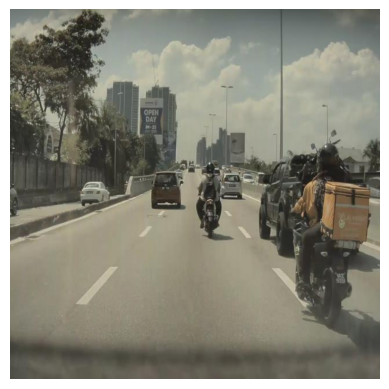

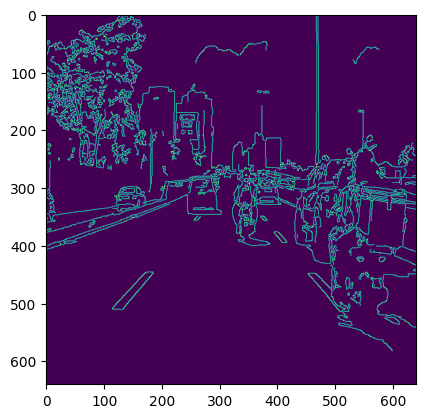

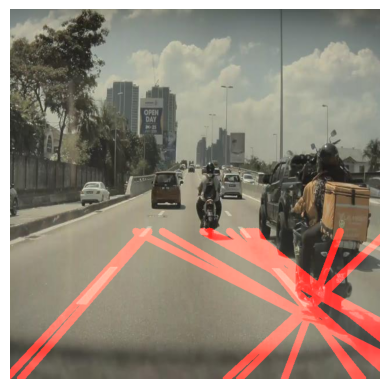

In [ ]:
I = io.imread("/content/road_lane_instance_segmentation/train2017/2023-06-15_14-33-00-front_mp4_1980_jpg.rf.a2604c5ded13fb3154e4c4e2249cc941.jpg")
plt.axis('off')  # Turn off axis labels
plt.imshow(I)  # Display the image
plt.show()  # Show the plot

I1 = frame_processor(I, gaussian_blur=3)
plt.axis('off')
plt.imshow(I1)

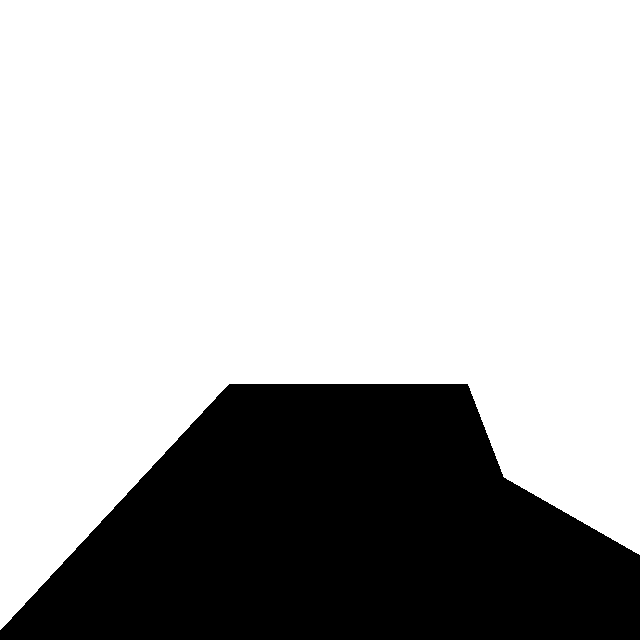

In [ ]:
cv2_imshow(process_frame_for_bitmap(I))

In [ ]:
import cv2
import numpy as np

def selective_canny(image, lower_color_bound, upper_color_bound, low_threshold, high_threshold):
    """
    Apply Canny edge detection selectively based on a specific color range.

    Parameters:
        image: Input BGR image.
        lower_color_bound: Lower bound of the color range in HSV.
        upper_color_bound: Upper bound of the color range in HSV.
        low_threshold: First threshold for the hysteresis procedure in Canny.
        high_threshold: Second threshold for the hysteresis procedure in Canny.

    Returns:
        edges: Binary image showing edges detected within the specific color range.
    """
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a mask for the specified color range
    mask = cv2.inRange(hsv_image, lower_color_bound, upper_color_bound)

    # Apply the mask to the original image to keep only the pixels within the color range
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    cv2_imshow(masked_image)

    # Convert the masked image to grayscale for edge detection
    grayscale = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(grayscale, (3, 3), 0)

    # Apply Canny edge detection on the masked region
    edges = cv2.Canny(blurred, low_threshold, high_threshold)

    return edges

# Example usage
image = cv2.imread('/content/road_lane_instance_segmentation/train2017/2023-06-15_14-33-00-front_mp4_1980_jpg.rf.a2604c5ded13fb3154e4c4e2249cc941.jpg')  # Load the input image

# Define the color range (example: detect white color)
lower_white = np.array([0, 0, 100])
upper_white = np.array([180, 25, 255])

# Apply selective Canny edge detection for the yellow color range
edges = selective_canny(image, lower_yellow, upper_yellow, low_threshold=50, high_threshold=150)

# Display the result
cv2_imshow(edges)

NameError: name 'lower_yellow' is not defined